# Exporting LLM Runs and Feedback
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langsmith-cookbook/blob/main/exploratory-data-analysis/exporting-llm-runs-and-feedback/llm_run_etl.ipynb)

Understanding how your LLM app interacts with users is crucial. LangSmith offers a number of useful ways to interact with and annotate trace data directly in the app. You can also easily query that trace data so you can process it with your tool of choice.

This tutorial guides you through exporting LLM traces and associated feedback from LangSmith for further analysis. By the end, you'll be able to export a flat table of LLM run information that you can analyze, enrich, or use for model training.

Before we start, ensure you have a LangChain project with some logged traces. You can generate some using almost any of the other recipes in this cookbook. The overall steps will be:

1. Query runs, filtering by time, tags, or other attributes.
2. Add in associated feedback metrics (if captured)
3. Export to analysis tool.

To make things easy, we will be loading the data into a pandas dataframe. We will be doing the ETL on LLM runs logged from LangChain, but you can modify the code below to handle whatever schema is used by your deployed model. Now let's set up our environment!

#### Setup

First, install langsmith and pandas and set your langsmith API key to connect to your project.
We will also install LangChain to use one of its formatting utilities.

In [66]:
# %pip install --upgrade --force-reinstall langchain langsmith pandas seaborn --quiet
import os  # Add this line at the beginning of your code

In [67]:
%env LANGCHAIN_API_KEY='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'
# %pip install --upgrade pandas

env: LANGCHAIN_API_KEY='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'


In [68]:
from langsmith import Client
import pandas as pd

client = Client()

dp_batch = {"name": "data_processor", "batch_id": "2117_batch"}
mc_batch = {"name": "model_converter", "batch_id": "7121_batch"}
# sg_batch = {"name": "sketch_generator", "batch_id": "1730_batch"}
sg_batch = {"name": "sketch_generator", "batch_id": "7058_batch"}

## 1. Query Runs
 query and save to json files
 


In [69]:
from datetime import datetime, timedelta
from datetime import timezone
import json

# batch_tests 10.28:
#   data_processor: batch_id: 2117_batch
#   model_converter: batch_id: 7121_batch
#   sketch_generator: batch_id: 1730_batch

#   sketch_generato2: batch_id: 2172_batch


def run_to_dict(run):
    return {
        "id": str(run.id),
        "name": run.name,
        "timing": {
            "start_time": run.start_time.strftime("%Y-%m-%d %H:%M:%S.%f"),
            "end_time": run.end_time.strftime("%Y-%m-%d %H:%M:%S.%f"),
        },
        "run_type": run.run_type,
        "metadata": {
            "trace_id": run.extra.get("metadata", {}).get("trace_id"),
            "num_run": run.extra.get("metadata", {}).get("num_run"),
            "batch_id": run.extra.get("metadata", {}).get("batch_id"),
            "network_latency": run.extra.get("metadata", {}).get("network_latency"),
            "ls_method": run.extra.get("metadata", {}).get("ls_method"),
            "revision_id": run.extra.get("metadata", {}).get("revision_id"),
        },
        "runtime": run.extra.get("runtime", {}),
        "tokens": {
            "prompt_tokens": run.prompt_tokens,
            "completion_tokens": run.completion_tokens,
            "total_tokens": run.total_tokens,
        },
        "cost": {
            "prompt_cost": float(run.prompt_cost) if run.prompt_cost else None,
            "completion_cost": (
                float(run.completion_cost) if run.completion_cost else None
            ),
            "total_cost": float(run.total_cost) if run.total_cost else None,
        },
        "status": run.status,
        "session_id": str(run.session_id) if run.session_id else None,
        "child_run_ids": (
            [str(run_id) for run_id in run.child_run_ids] if run.child_run_ids else []
        ),
        "tags": run.tags,
    }


def convert_runs_to_json(runs):
    # Convert list of Run objects to list of dicts
    runs_data = [run_to_dict(run) for run in runs]
    return runs_data


def save_runs(current_batch):
    runs = list(
        client.list_runs(
            project_name="default",
            start_time=datetime.now(timezone.utc) - timedelta(days=2),
            run_type="llm",
            # filter=f'and(has(tags, \'gpt-4o-mini\'),has(tags, {task_type}))',
            filter=f"and(eq(metadata_key, 'batch_id'), eq(metadata_value, '{current_batch['batch_id']}'))",
        )
    )

    output_dir = "raw_export"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    output_file = (
        f"{output_dir}/js_{current_batch['name']}_{current_batch['batch_id']}.json"
    )
    runs_data = convert_runs_to_json(runs)
    # Write to JSON file

    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(runs_data, f, indent=2)


current_batch = sg_batch
print(current_batch["batch_id"])
save_runs(current_batch)

7058_batch


## Start from reading data from saved json files

In [70]:
import pandas as pd
import json

current_batch = sg_batch


# Open json file
def load_runs_df(json_path):
    # Read JSON file
    with open(json_path, "r") as f:
        data = json.load(f)

    # Flatten nested structures
    flattened_data = []
    for run in data:
        flat_run = {
            "id": run["id"],
            "name": run["name"],
            "start_time": run["timing"]["start_time"],
            "end_time": run["timing"]["end_time"],
            "run_type": run["run_type"],
            # Metadata
            "trace_id": run["metadata"]["trace_id"],
            "num_run": run["metadata"]["num_run"],
            "batch_id": run["metadata"]["batch_id"],
            "network_latency": run["metadata"]["network_latency"],
            # Runtime
            "sdk_version": run["runtime"]["sdk_version"],
            "platform": run["runtime"]["platform"],
            "python_version": run["runtime"]["runtime_version"],
            "langchain_version": run["runtime"]["langchain_version"],
            # Tokens
            "prompt_tokens": run["tokens"]["prompt_tokens"],
            "completion_tokens": run["tokens"]["completion_tokens"],
            "total_tokens": run["tokens"]["total_tokens"],
            # Cost
            "prompt_cost": run["cost"]["prompt_cost"],
            "completion_cost": run["cost"]["completion_cost"],
            "total_cost": run["cost"]["total_cost"],
            "status": run["status"],
            "session_id": run["session_id"],
            "child_run_ids": ",".join(run["child_run_ids"]),  # Convert list to string
            "tags": ",".join(run["tags"]),  # Convert list to string
        }
        flattened_data.append(flat_run)

    # Create DataFrame
    df = pd.DataFrame(flattened_data)

    # Convert timestamp strings to datetime
    df["start_time"] = pd.to_datetime(df["start_time"])
    df["end_time"] = pd.to_datetime(df["end_time"])

    return df


# Usage
json_path = f"raw_export/js_{current_batch['name']}_{current_batch['batch_id']}.json"
df = load_runs_df(json_path)

# In-place deletion of the duplicated rows 'ChatOpenAI' and rows ending with 'task_stack'
df.drop(df[df["name"] == "ChatOpenAI"].index, inplace=True)

df.drop(df[df["name"].str.endswith("task_stack")].index, inplace=True)

df.reset_index(drop=True, inplace=True)


# Add latency column in seconds
df["latency"] = (df["end_time"] - df["start_time"]).dt.total_seconds()

# Show the new column
print("\nLatency statistics (in seconds):")
print(df["latency"].describe())

# Show sample rows with timestamps and latency
print("\nSample rows with latency:")
print(df[["name", "start_time", "end_time", "latency"]].head())

# Now you can do analysis
print(df.head())
print("\nDataFrame Info:")
print(df.info())


Latency statistics (in seconds):
count    311.000000
mean       7.467237
std        3.756658
min        0.000643
25%        5.377804
50%        8.083759
75%        9.515470
max       21.564587
Name: latency, dtype: float64

Sample rows with latency:
                    name                 start_time  \
0  97_sg_error_handling5 2024-11-11 18:16:19.351607   
1  97_sg_error_handling4 2024-11-11 18:15:42.676170   
2  97_sg_error_handling3 2024-11-11 18:15:07.190388   
3  97_sg_error_handling2 2024-11-11 18:14:30.649708   
4      97_sg_sketch_gen1 2024-11-11 18:13:46.932693   

                    end_time    latency  
0 2024-11-11 18:16:28.068424   8.716817  
1 2024-11-11 18:15:53.419165  10.742995  
2 2024-11-11 18:15:16.831913   9.641525  
3 2024-11-11 18:14:41.267798  10.618090  
4 2024-11-11 18:14:05.932267  18.999574  
                                     id                   name  \
0  5c93e5f2-af9b-46f3-9831-441b465abea0  97_sg_error_handling5   
1  1e9be3ff-5843-4427-814a-00dd4ae

## Drop the columns that are not needed




In [71]:
# List of columns to drop
columns_to_drop = [
    "session_id",
    "child_run_ids",
    "sdk_version",
    # "start_time",
    "end_time",
    "platform",
    "python_version",
    "langchain_version",
    "run_type",
]

# Drop the columns
for col in columns_to_drop:
    if col in df.columns:
        df = df.drop(columns=[col])
# Show remaining columns
print("Remaining columns:")
print(df.columns.tolist())

Remaining columns:
['id', 'name', 'start_time', 'trace_id', 'num_run', 'batch_id', 'network_latency', 'prompt_tokens', 'completion_tokens', 'total_tokens', 'prompt_cost', 'completion_cost', 'total_cost', 'status', 'tags', 'latency']


## Sort the dataframe by num_run


In [72]:
# Sort DataFrame by num_run
df = df.sort_values("num_run")

# Reset index after sorting
df = df.reset_index(drop=True)

# Display first few rows to verify sorting
print("Sorted DataFrame by num_run:")
print(df[["num_run", "name", "trace_id"]].head())

# Optional: Display full range of num_run
print("\nRange of num_run values:")
print(f"Min: {df['num_run'].min()}, Max: {df['num_run'].max()}")

Sorted DataFrame by num_run:
   num_run                                   name  trace_id
0        0                     29_sg_spec_filling  293576a4
1        0  29_sg_failure_signal_sketch_generator  293576a4
2        0                  29_sg_error_handling5  293576a4
3        0                      29_sg_sketch_gen1  293576a4
4        0                  29_sg_error_handling3  293576a4

Range of num_run values:
Min: 0, Max: 49


## Combine the subtasks into one task (based on the shared trace_id)

In [73]:
import pandas as pd
import numpy as np


def process_df(df):
    # 1. Process names - take first 2 sections
    df["name"] = df["name"].apply(lambda x: "_".join(x.split("_")[:2]))

    # Check name consistency within trace_id groups
    name_consistency = df.groupby("trace_id")["name"].nunique()
    if not all(name_consistency == 1):
        print("Warning: Inconsistent names found within trace_id groups:")
        print(name_consistency[name_consistency > 1])

    # 2. Remove id column
    df = df.drop(columns=["id"])

    # Check consistency of num_run, batch_id, tags within trace_id groups
    for col in ["num_run", "batch_id", "tags"]:
        consistency = df.groupby("trace_id")[col].nunique()
        if not all(consistency == 1):
            print(f"Warning: Inconsistent {col} found within trace_id groups:")
            print(consistency[consistency > 1])

    # Columns to aggregate
    sum_columns = [
        "latency",
        "network_latency",
        "prompt_tokens",
        "completion_tokens",
        "total_tokens",
        "prompt_cost",
        "completion_cost",
        "total_cost",
    ]

    def aggregate_status(x):
        if "error" in x.values:
            return "error"
        return "success" if all(x == "success") else "error"

    # Aggregate by trace_id
    agg_dict = {
        "name": "first",
        "num_run": "first",
        "batch_id": "first",
        "tags": "first",
        "status": aggregate_status,
        "start_time": "first",
    }

    # Add sum aggregation for numeric columns
    for col in sum_columns:
        agg_dict[col] = lambda x: x[x.notna()].sum()

    # Perform groupby and aggregation
    df_combined = df.groupby("trace_id").agg(agg_dict).reset_index()

    # 7. Reorder columns
    column_order = [
        "num_run",
        "name",
        "trace_id",
        "latency",
        "network_latency",
        "total_tokens",
        "total_cost",
        "status",
        "batch_id",
        "tags",
        "prompt_tokens",
        "completion_tokens",
        "prompt_cost",
        "completion_cost",
        "start_time",
    ]
    df_combined = df_combined[column_order]

    # 8. Sort by num_run
    df_combined = df_combined.sort_values("num_run")

    return df_combined


# Apply the processing
df_processed = process_df(df)

# Display results
print("\nProcessed DataFrame Info:")
print(df_processed.info())
print("\nFirst few rows:")
print(df_processed.head())

# Additional verification
print("\nUnique names per trace_id after processing:")
print(df_processed.groupby("trace_id")["name"].nunique().value_counts())


Processed DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 7 to 27
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   num_run            50 non-null     int64         
 1   name               50 non-null     object        
 2   trace_id           50 non-null     object        
 3   latency            50 non-null     float64       
 4   network_latency    50 non-null     float64       
 5   total_tokens       50 non-null     int64         
 6   total_cost         50 non-null     float64       
 7   status             50 non-null     object        
 8   batch_id           50 non-null     object        
 9   tags               50 non-null     object        
 10  prompt_tokens      50 non-null     int64         
 11  completion_tokens  50 non-null     int64         
 12  prompt_cost        50 non-null     float64       
 13  completion_cost    50 non-null     float64   

## Calculate clean latency


In [74]:
# Calculate new latency
df_processed["latency"] = df_processed["latency"] - df_processed["network_latency"]

# Show results
print("\nAfter calculation:")
print(df_processed[["latency", "network_latency"]].head())

# Check for any negative values (which might indicate issues)
negative_latency = df_processed[df_processed["latency"] < 0]
if len(negative_latency) > 0:
    print("\nWarning: Found negative latency values:")
    print(negative_latency[["trace_id", "latency", "network_latency"]])

# Remove network_latency column
df_processed = df_processed.drop(columns=["network_latency"])

# Reorder columns
column_order = [
    "num_run",
    "name",
    "trace_id",
    "latency",
    "total_tokens",
    "total_cost",
    "status",
    "batch_id",
    "tags",
    "prompt_tokens",
    "completion_tokens",
    "prompt_cost",
    "completion_cost",
    "start_time",
]
df_processed = df_processed[column_order]


After calculation:
      latency  network_latency
7   43.026410         1.223651
39  47.574252         1.344750
33  40.996180         1.419785
48  41.083940         1.151863
21  43.331901         1.406733


## Save to csv

In [75]:
import os


# Create the path if it doesn't exist
os.makedirs("processed_data", exist_ok=True)
# Create the filename
filename = (
    f"processed_data/clean_{current_batch['name']}_{current_batch['batch_id']}.csv"
)

# Save to CSV
df_processed.to_csv(filename, index=False)

print(f"DataFrame saved to: {filename}")

# Verify the file was created
if os.path.exists(filename):
    print(f"File size: {os.path.getsize(filename)} bytes")
    # Show first few lines of saved file
    print("\nFirst few lines of saved file:")
    with open(filename, "r") as f:
        print(f.readline().strip())  # Headers
        print(f.readline().strip())  # First data row

DataFrame saved to: processed_data/clean_sketch_generator_7058_batch.csv
File size: 8679 bytes

First few lines of saved file:
num_run,name,trace_id,latency,total_tokens,total_cost,status,batch_id,tags,prompt_tokens,completion_tokens,prompt_cost,completion_cost,start_time
0,29_sg,293576a4,43.026409612213136,22202,0.08771,error,7058_batch,"benchmark,gpt-4o,sketch_generator",17908,4294,0.044770000000000004,0.04294,2024-11-11 16:00:17.936793


In [76]:
import pandas as pd
import numpy as np


def validate_data(df, task_name):
    print(f"\n{'='*50}")
    print(f"Validation for {task_name}")
    print(f"{'='*50}")

    # Cost Validation
    print("\n=== Cost Validation ===")
    df["calculated_total_cost"] = df["prompt_cost"] + df["completion_cost"]
    df["cost_difference"] = (df["total_cost"] - df["calculated_total_cost"]).abs()

    # Token Validation
    print("\n=== Token Validation ===")
    df["calculated_total_tokens"] = df["prompt_tokens"] + df["completion_tokens"]
    df["token_difference"] = (df["total_tokens"] - df["calculated_total_tokens"]).abs()

    # Check for mismatches
    cost_threshold = 0.0001
    cost_mismatches = df[df["cost_difference"] > cost_threshold]
    token_mismatches = df[df["token_difference"] > 0]  # Tokens should match exactly

    # Print results
    print("\nCost Analysis:")
    print(f"Total rows: {len(df)}")
    print(f"Rows with cost mismatches: {len(cost_mismatches)}")
    if len(cost_mismatches) > 0:
        print("\nSample of cost mismatches:")
        print(
            cost_mismatches[
                [
                    "prompt_cost",
                    "completion_cost",
                    "calculated_total_cost",
                    "total_cost",
                    "cost_difference",
                ]
            ]
            .head()
            .to_string()
        )

    print("\nToken Analysis:")
    print(f"Total rows: {len(df)}")
    print(f"Rows with token mismatches: {len(token_mismatches)}")
    if len(token_mismatches) > 0:
        print("\nSample of token mismatches:")
        print(
            token_mismatches[
                [
                    "prompt_tokens",
                    "completion_tokens",
                    "calculated_total_tokens",
                    "total_tokens",
                    "token_difference",
                ]
            ]
            .head()
            .to_string()
        )

    # Statistics
    print("\nStatistics:")
    print("Costs:")
    print(f"Mean difference: {df['cost_difference'].mean():.6f}")
    print(f"Max difference: {df['cost_difference'].max():.6f}")
    print("\nTokens:")
    print(f"Mean difference: {df['token_difference'].mean():.1f}")
    print(f"Max difference: {df['token_difference'].max():.1f}")


# Define batches
batches = {
    "Data Processor": dp_batch,
    "Model Converter": mc_batch,
    "Sketch Generator": sg_batch,
}

# Load and validate each dataset
data_dir = "processed_data"
for task_name, batch_info in batches.items():
    try:
        input_csv = f"clean_{batch_info['name']}_{batch_info['batch_id']}.csv"
        df = pd.read_csv(f"{data_dir}/{input_csv}")
        validate_data(df, task_name)
    except Exception as e:
        print(f"\nError processing {task_name}: {str(e)}")


Error processing Data Processor: [Errno 2] No such file or directory: 'processed_data/clean_data_processor_2117_batch.csv'

Error processing Model Converter: [Errno 2] No such file or directory: 'processed_data/clean_model_converter_7121_batch.csv'

Validation for Sketch Generator

=== Cost Validation ===

=== Token Validation ===

Cost Analysis:
Total rows: 50
Rows with cost mismatches: 0

Token Analysis:
Total rows: 50
Rows with token mismatches: 0

Statistics:
Costs:
Mean difference: 0.000000
Max difference: 0.000000

Tokens:
Mean difference: 0.0
Max difference: 0.0


# Plot the success distribution among the batch tests


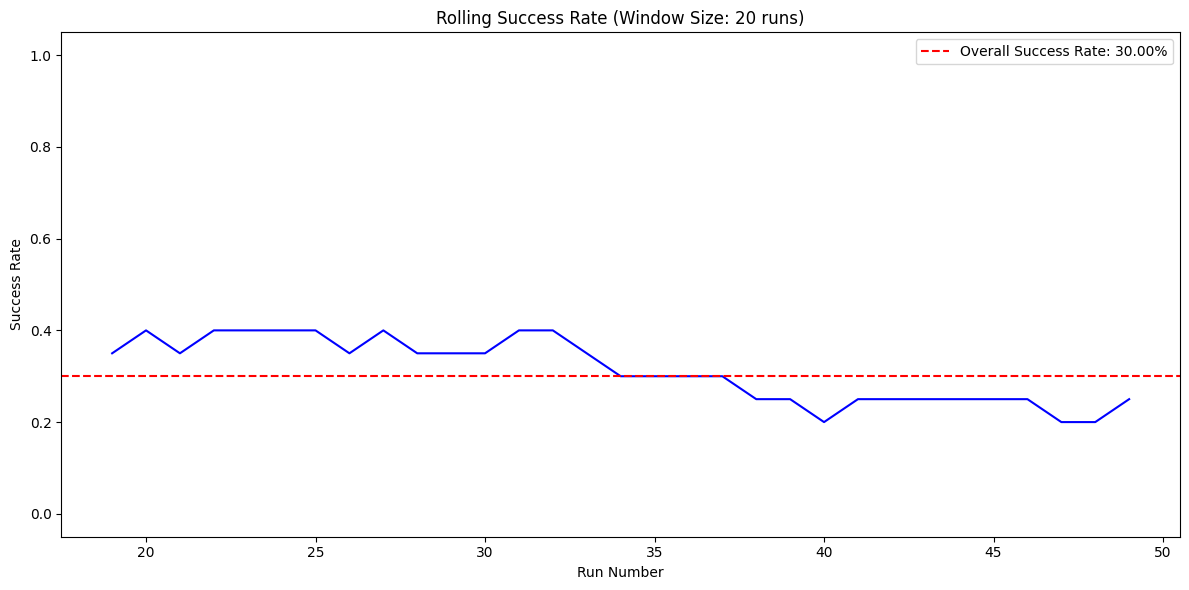

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a rolling window success rate plot
plt.figure(figsize=(12, 6))

# Convert status to binary (1 for success, 0 for error)
df["success_binary"] = (df["status"] == "success").astype(int)

# Calculate rolling success rate
window_size = 20  # adjust this value based on your data
rolling_success_rate = df["success_binary"].rolling(window=window_size).mean()

# Plot using num_run instead of start_time
plt.plot(df["num_run"], rolling_success_rate, "b-")
plt.axhline(
    y=df["success_binary"].mean(),
    color="r",
    linestyle="--",
    label=f'Overall Success Rate: {df["success_binary"].mean():.2%}',
)

plt.title(f"Rolling Success Rate (Window Size: {window_size} runs)")
plt.xlabel("Run Number")
plt.ylabel("Success Rate")
plt.ylim(-0.05, 1.05)

# Format x-axis to show integers
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: int(x)))

plt.legend()
plt.tight_layout()
plt.show()

# Success rate for the first/final n runs
 

In [89]:
# Get first 30 runs
first_30 = df.head(30)

# Calculate success rate
success_rate = (first_30["status"] == "success").mean() * 100

print(f"Success rate for first 30 runs: {success_rate:.2f}%")

# Optional: detailed breakdown
success_count = (first_30["status"] == "success").sum()
error_count = (first_30["status"] == "error").sum()
print(f"\nDetailed breakdown:")
print(f"Successes: {success_count}")
print(f"Errors: {error_count}")

Success rate for first 30 runs: 33.33%

Detailed breakdown:
Successes: 10
Errors: 20
